# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


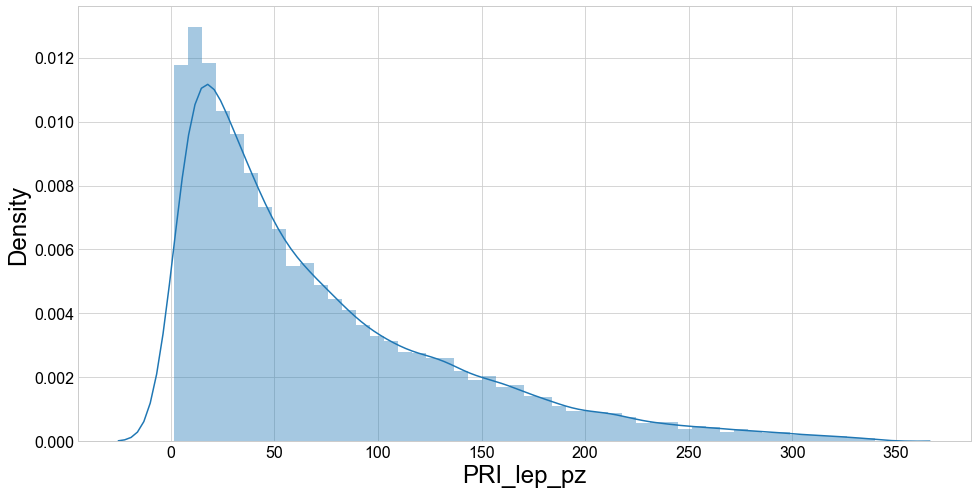

In [6]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.666s 


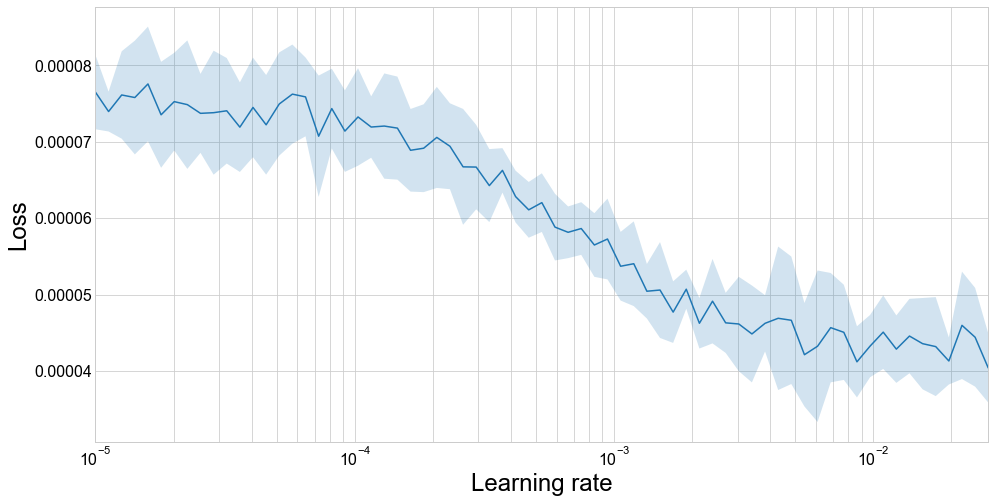

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.925225831237326e-05
2 New best found: 3.62509926084336e-05
3 New best found: 3.55454335784786e-05
5 New best found: 3.473642935059517e-05
6 New best found: 3.399973198941842e-05
7 New best found: 3.393717543381187e-05
11 New best found: 3.370714741397573e-05
12 New best found: 3.313854459698232e-05
13 New best found: 3.308069069862895e-05
14 New best found: 3.295282225095584e-05
15 New best found: 3.294041574527617e-05
21 New best found: 3.2896235378271214e-05
23 New best found: 3.282647798342813e-05
24 New best found: 3.2797008222218965e-05
25 New best found: 3.272165489161277e-05
27 New best found: 3.251226585027088e-05
28 New best found: 3.24309939889186e-05
29 New best found: 3.238111456903375e-05
30 New best found: 3.2374717529927244e-05
31 New best found: 3.237145588046354e-05
48 New best found: 3.231668275623004e-05
50 New best found: 3.221859692502

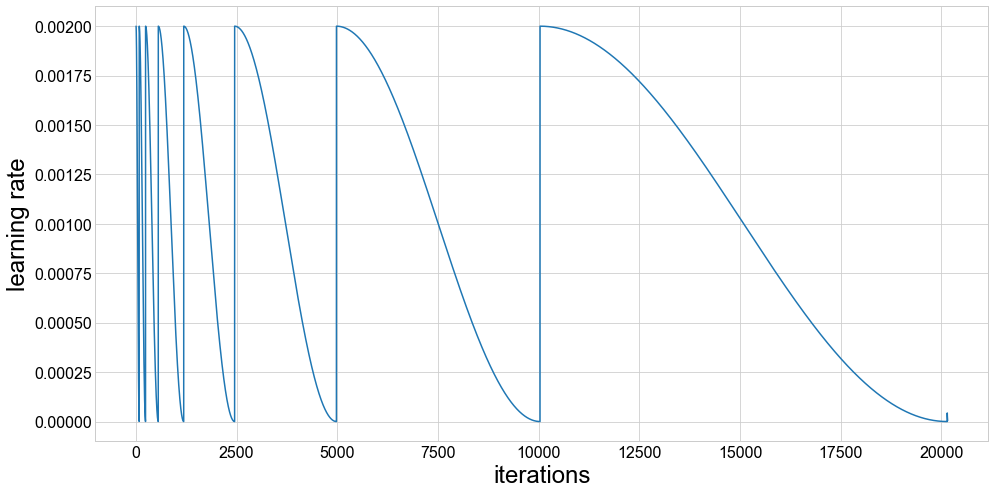

Fold took 138.491s

Training model 2 / 10
Using cosine LR annealing
1 New best found: 3.935384774098616e-05
2 New best found: 3.703533780151013e-05
3 New best found: 3.6288468566947655e-05
4 New best found: 3.594812666082087e-05
5 New best found: 3.538759407719377e-05
6 New best found: 3.503365867445263e-05
7 New best found: 3.480331986193626e-05
10 New best found: 3.474171987696883e-05
11 New best found: 3.439478042737325e-05
12 New best found: 3.422729577347626e-05
13 New best found: 3.4006123558037065e-05
14 New best found: 3.3868545627672873e-05
15 New best found: 3.3838505917937105e-05
20 New best found: 3.381414346463668e-05
25 New best found: 3.365690326199949e-05
26 New best found: 3.3521024917732936e-05
27 New best found: 3.331669428711085e-05
29 New best found: 3.330908952140183e-05
30 New best found: 3.3298774271497576e-05
51 New best found: 3.32795878497878e-05
53 New best found: 3.311223949556974e-05
54 New best found: 3.304401754721668e-05
60 New best found: 3.30424625350

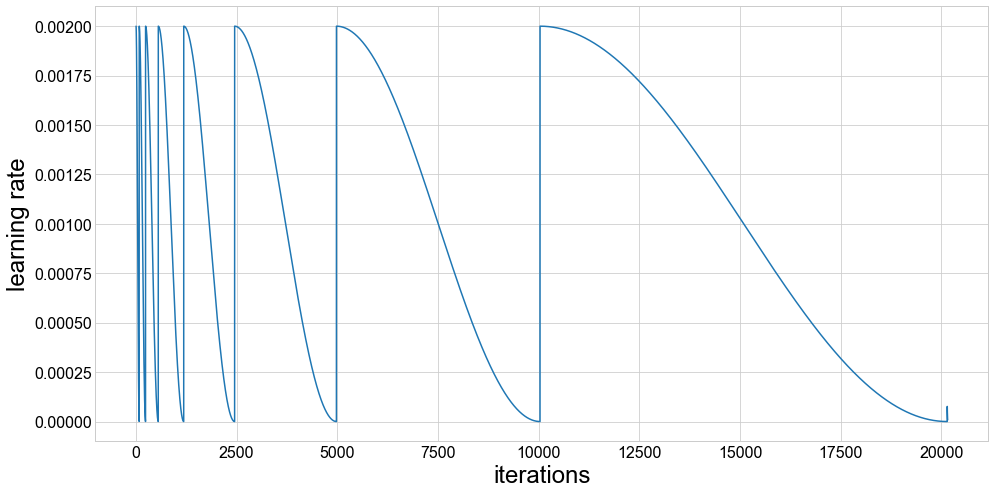

Fold took 140.857s

Training model 3 / 10
Using cosine LR annealing
1 New best found: 3.953944859094918e-05
2 New best found: 3.641721500753192e-05
3 New best found: 3.586549293540884e-05
5 New best found: 3.495525146427099e-05
6 New best found: 3.424031000031391e-05
7 New best found: 3.415535395033658e-05
10 New best found: 3.38931989914272e-05
11 New best found: 3.3573120033543094e-05
13 New best found: 3.3232021136791444e-05
14 New best found: 3.3181093154416885e-05
15 New best found: 3.3153467655938584e-05
23 New best found: 3.307005428796401e-05
24 New best found: 3.293525975313969e-05
25 New best found: 3.293059680581791e-05
27 New best found: 3.2675725783337836e-05
28 New best found: 3.257865562918596e-05
29 New best found: 3.251520202611573e-05
30 New best found: 3.251276332011912e-05
31 New best found: 3.251243697013706e-05
46 New best found: 3.2476703742577226e-05
47 New best found: 3.237527016317472e-05
50 New best found: 3.216908225876978e-05
53 New best found: 3.2165307248

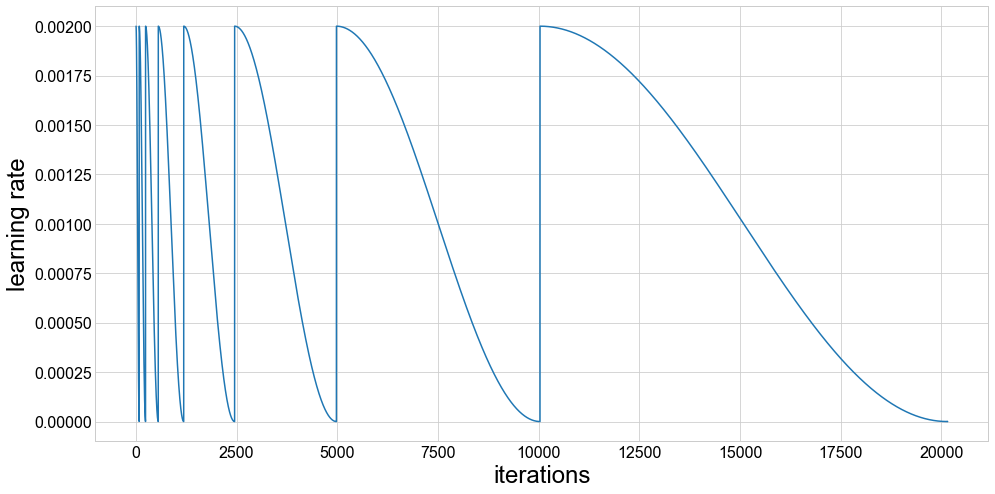

Fold took 147.416s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104371). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8973857697966735e-05
2 New best found: 3.6223090974223674e-05
3 New best found: 3.547365735069608e-05
4 New best found: 3.512367909451457e-05
5 New best found: 3.4392145795461314e-05
6 New best found: 3.416582178087387e-05
7 New best found: 3.395241761438305e-05
10 New best found: 3.3784542865345166e-05
11 New best found: 3.36209785198623e-05
12 New best found: 3.309725413791155e-05
13 New best found: 3.2941025009601895e-05
14 New best found: 3.2868769581702304e-05
15 New best found: 3.283343250749724e-05
23 New best found: 3.279428232253477e-05
24 New best found: 3.271841857459594e-05
25 New best found: 3.25725930063417e-05
26 New best found: 3.246811377677241e-05
27 New best found: 3.233396205713657e-05
29 New best found: 3.23190633549762e-05
30 New best found: 3.229634123147208e-05
31 New best found: 3.2289476302861723e-05
51 New best found: 3.225179285762403e-05
52 New best found: 3.2235933113511384e-05
53 New best found: 3.205430977807668e-05
58 New best found:

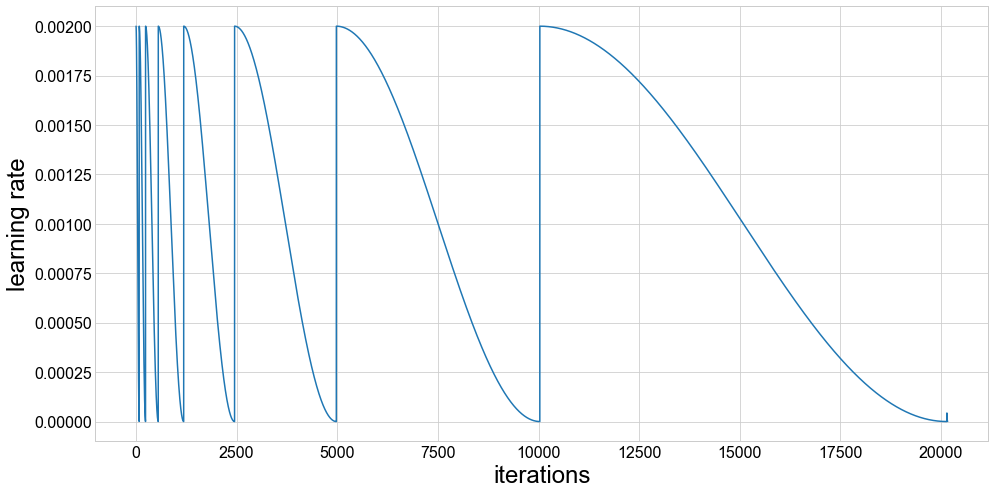

Fold took 153.814s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108595). Check your callbacks.
  % delta_t_median)


1 New best found: 3.988929494807962e-05
2 New best found: 3.7754152539127974e-05
3 New best found: 3.6433166018105115e-05
5 New best found: 3.5092161019565535e-05
6 New best found: 3.4776346509170255e-05
7 New best found: 3.4695543770794755e-05
9 New best found: 3.456692740292055e-05
10 New best found: 3.449889721086947e-05
11 New best found: 3.408171290066093e-05
12 New best found: 3.393546539155068e-05
13 New best found: 3.362879937194521e-05
14 New best found: 3.348970496590482e-05
15 New best found: 3.345681917999172e-05
24 New best found: 3.3204930851934476e-05
25 New best found: 3.31332574627595e-05
26 New best found: 3.310542886465555e-05
27 New best found: 3.2912355026928706e-05
28 New best found: 3.291100648639258e-05
29 New best found: 3.2871271060139406e-05
30 New best found: 3.28675722979824e-05
31 New best found: 3.286060351529159e-05
46 New best found: 3.275489616280538e-05
47 New best found: 3.273145459388616e-05
48 New best found: 3.259743606322445e-05
55 New best found

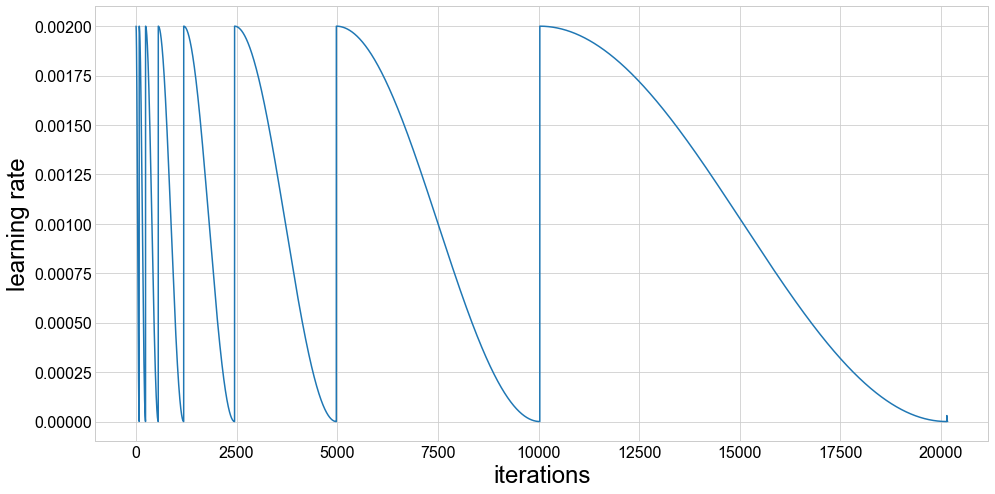

Fold took 157.411s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112514). Check your callbacks.
  % delta_t_median)


1 New best found: 3.901351418678638e-05
2 New best found: 3.665854210733849e-05
3 New best found: 3.563789050854195e-05
4 New best found: 3.5307034867792965e-05
5 New best found: 3.498153884708154e-05
6 New best found: 3.423796566483543e-05
7 New best found: 3.414126971651784e-05
10 New best found: 3.365552705330019e-05
12 New best found: 3.3393157708533695e-05
13 New best found: 3.330276578841579e-05
14 New best found: 3.308237833604585e-05
15 New best found: 3.3077496223781245e-05
22 New best found: 3.286447079257063e-05
25 New best found: 3.284666205432302e-05
26 New best found: 3.271101152297316e-05
28 New best found: 3.26783616243764e-05
29 New best found: 3.259622554114666e-05
30 New best found: 3.259320818318047e-05
31 New best found: 3.259169096071763e-05
49 New best found: 3.246755411376973e-05
51 New best found: 3.232726448562989e-05
54 New best found: 3.228849447227205e-05
56 New best found: 3.2283420031275964e-05
57 New best found: 3.224551734882567e-05
58 New best found: 3

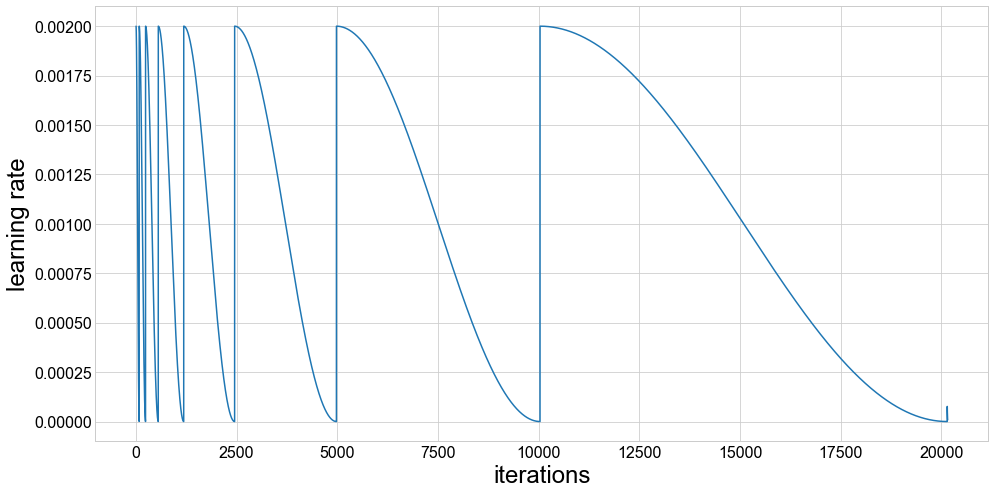

Fold took 154.409s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242555). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121663). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7977826698624994e-05
2 New best found: 3.558660532726208e-05
3 New best found: 3.4444488181907216e-05
4 New best found: 3.389579481736291e-05
5 New best found: 3.3695643667306285e-05
6 New best found: 3.319966502313037e-05
7 New best found: 3.299560387677047e-05
8 New best found: 3.297621405945392e-05
10 New best found: 3.257891553948866e-05
12 New best found: 3.206555390788708e-05
13 New best found: 3.172141095274128e-05
14 New best found: 3.1711535081558396e-05
15 New best found: 3.167443490237929e-05
20 New best found: 3.164875774236861e-05
22 New best found: 3.1532156985485926e-05
24 New best found: 3.1462893181014804e-05
25 New best found: 3.136215579725103e-05
26 New best found: 3.134999979229178e-05
27 New best found: 3.123876654717606e-05
28 New best found: 3.1156769652443473e-05
29 New best found: 3.109554831899004e-05
30 New best found: 3.1031505759165154e-05
31 New best found: 3.1023933297547045e-05
49 New best found: 3.079170879209414e-05
56 New best fou

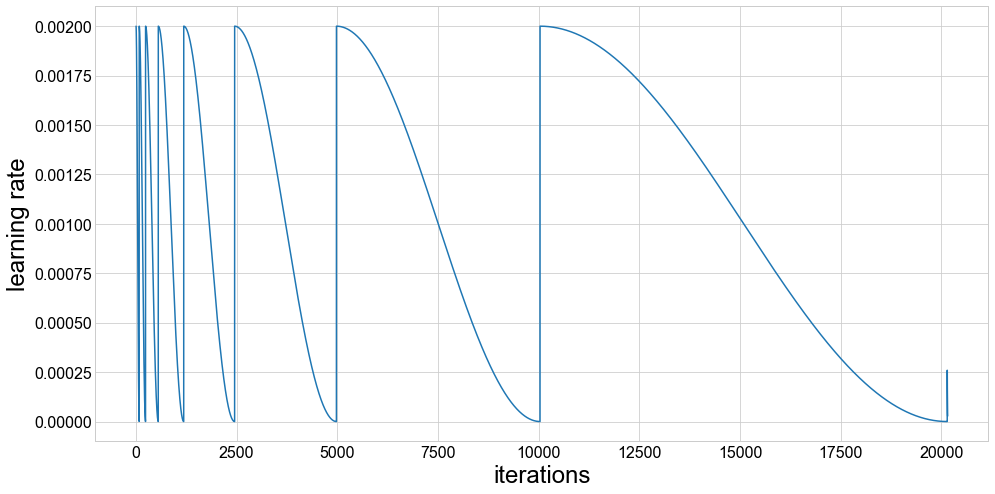

Fold took 157.861s

Training model 8 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251102). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126099). Check your callbacks.
  % delta_t_median)


1 New best found: 3.916190557786416e-05
2 New best found: 3.6552765182857274e-05
3 New best found: 3.582952640703762e-05
4 New best found: 3.5599387248667956e-05
5 New best found: 3.512447356948129e-05
6 New best found: 3.472721254902344e-05
7 New best found: 3.461448723461235e-05
11 New best found: 3.424947599110499e-05
12 New best found: 3.41638419781477e-05
13 New best found: 3.368436922699581e-05
14 New best found: 3.35959834244214e-05
21 New best found: 3.338382145702197e-05
23 New best found: 3.335460854086389e-05
24 New best found: 3.328271291110694e-05
26 New best found: 3.3096861929904426e-05
29 New best found: 3.298431344665772e-05
30 New best found: 3.297251606003579e-05
31 New best found: 3.296310909380446e-05
45 New best found: 3.284826763648282e-05
49 New best found: 3.266399335409471e-05
54 New best found: 3.261777672472731e-05
55 New best found: 3.257963862722588e-05
56 New best found: 3.2487246055133804e-05
59 New best found: 3.2467861528097234e-05
60 New best found: 3

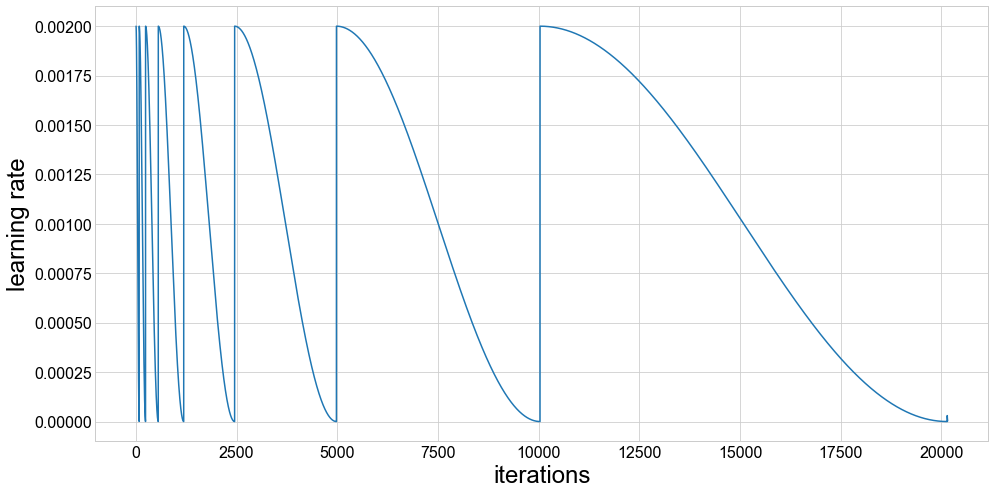

Fold took 161.551s

Training model 9 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275070). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137868). Check your callbacks.
  % delta_t_median)


1 New best found: 4.070571350299876e-05
2 New best found: 3.7577299711846246e-05
3 New best found: 3.672317374942151e-05
5 New best found: 3.559251500374141e-05
6 New best found: 3.516340454626383e-05
7 New best found: 3.49424042097658e-05
11 New best found: 3.4839259418951506e-05
12 New best found: 3.4295022590509375e-05
13 New best found: 3.388081556652987e-05
14 New best found: 3.376046922260091e-05
15 New best found: 3.374488296882201e-05
23 New best found: 3.339616868969631e-05
24 New best found: 3.3198722730852293e-05
28 New best found: 3.3161396931951456e-05
30 New best found: 3.310845922223473e-05
31 New best found: 3.3093852742235775e-05
46 New best found: 3.294372381157669e-05
50 New best found: 3.2780445888757565e-05
52 New best found: 3.271805233302886e-05
53 New best found: 3.2707598361717613e-05
54 New best found: 3.2666387642304935e-05
55 New best found: 3.25273597032817e-05
99 New best found: 3.24747686304235e-05
103 New best found: 3.231011431482256e-05
109 New best fo

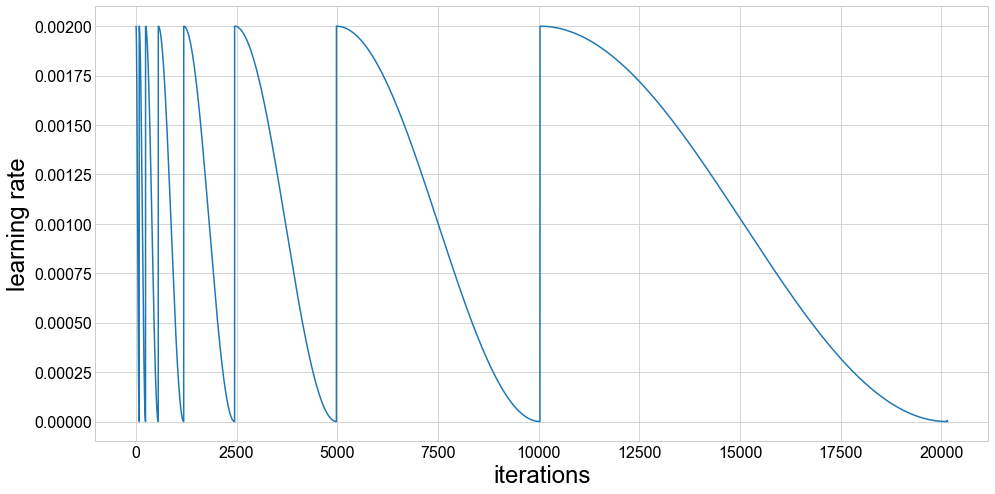

Fold took 165.381s

Training model 10 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282899). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141729). Check your callbacks.
  % delta_t_median)


1 New best found: 3.911956465453841e-05
2 New best found: 3.636799832165707e-05
3 New best found: 3.578617956081871e-05
4 New best found: 3.545461721660103e-05
5 New best found: 3.491429325222271e-05
6 New best found: 3.443344257393619e-05
7 New best found: 3.422440419672057e-05
10 New best found: 3.4200854848313614e-05
11 New best found: 3.3832568473007997e-05
12 New best found: 3.3609243445971515e-05
13 New best found: 3.3329740521730855e-05
14 New best found: 3.324772350897547e-05
22 New best found: 3.3141298192640536e-05
25 New best found: 3.298308469529729e-05
26 New best found: 3.289497257355834e-05
27 New best found: 3.284097438372555e-05
28 New best found: 3.280234909907449e-05
30 New best found: 3.277502773707965e-05
31 New best found: 3.276237816462526e-05
47 New best found: 3.2685392232087904e-05
49 New best found: 3.2668121706228706e-05
52 New best found: 3.2529753157723464e-05
54 New best found: 3.249585224693874e-05
55 New best found: 3.2462286071677227e-05
56 New best fo

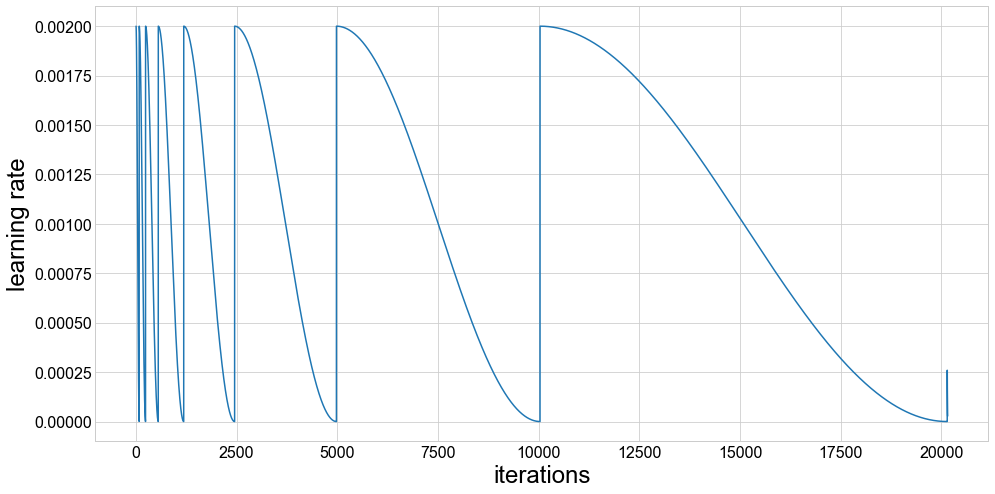

Fold took 166.996s


______________________________________
Training finished
Cross-validation took 1547.620s 


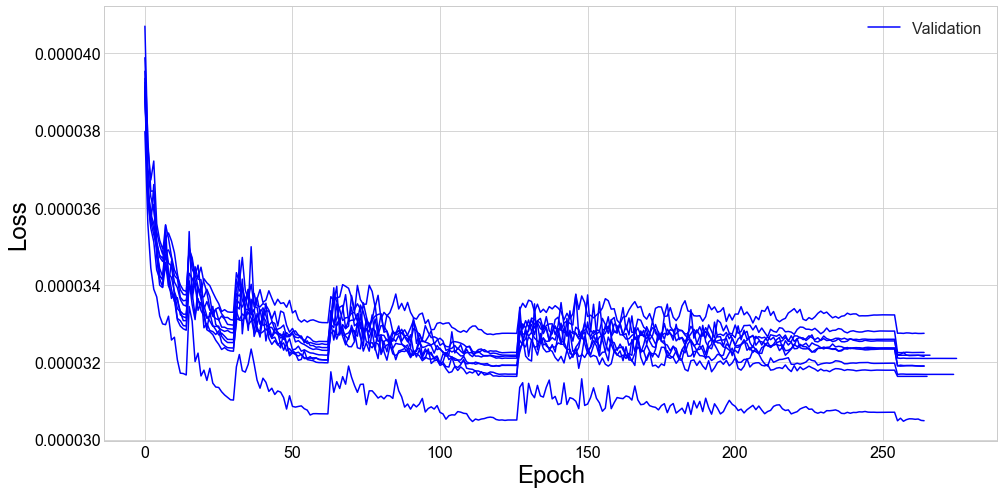

Mean loss = 3.19e-05 +- 2e-07
Mean wAUC = 0.0638 +- 0.0008
Mean AUC = 0.0992 +- 0.0007
Mean AMS = 3.95 +- 0.09
Mean cut = 0.966 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 6 with loss = 3.0468343928805554e-05
Model 1 is 2 with loss = 3.1637561479874424e-05
Model 2 is 3 with loss = 3.1688372885160045e-05
Model 3 is 5 with loss = 3.190019014980417e-05
Model 4 is 0 with loss = 3.1900364752344806e-05
Model 5 is 4 with loss = 3.210147181162029e-05
Model 6 is 9 with loss = 3.214854421603377e-05
Model 7 is 8 with loss = 3.2184485523433384e-05
Model 8 is 7 with loss = 3.224970244804508e-05
Model 9 is 1 with loss = 3.271848909259004e-05


## Response on validation data without TTA

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0013736432635996607s per sample

Predicting fold 2 out of 10
Prediction took 0.000223632464199909s per sample

Predicting fold 3 out of 10
Prediction took 0.0002208481531997677s per sample

Predicting fold 4 out of 10
Prediction took 0.00021622185579981304s per sample

Predicting fold 5 out of 10
Prediction took 0.000216142760799994s per sample

Predicting fold 6 out of 10
Prediction took 0.00021748464140036958s per sample

Predicting fold 7 out of 10
Prediction took 0.00022827502360014477s per sample

Predicting fold 8 out of 10
Prediction took 0.0002272388493998733s per sample

Predicting fold 9 out of 10
Prediction took 0.00022506265999982134s per sample

Predicting fold 10 out of 10
Prediction took 0.00021726509660002194s per sample



In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9030651398064315, weighted 0.9355832926094676


In [16]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9815609996142056, 0.9653963)

In [17]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.963+-0.009
Exact mean cut 0.96319289423991, corresponds to calc_ams of 3.887605345807668
CPU times: user 3.38 s, sys: 5.13 s, total: 8.51 s
Wall time: 1min 29s


(4.0, 0.963)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [18]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [19]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0037484454477998952s per sample

Predicting fold 2 out of 10
Prediction took 0.0035953698277997317s per sample

Predicting fold 3 out of 10
Prediction took 0.003697817192799994s per sample

Predicting fold 4 out of 10
Prediction took 0.0036968328880000625s per sample

Predicting fold 5 out of 10
Prediction took 0.003707283898800233s per sample

Predicting fold 6 out of 10
Prediction took 0.003827981242999522s per sample

Predicting fold 7 out of 10
Prediction took 0.0037848397087997s per sample

Predicting fold 8 out of 10
Prediction took 0.00360734457199942s per sample

Predicting fold 9 out of 10
Prediction took 0.0036243382561995533s per sample

Predicting fold 10 out of 10
Prediction took 0.0037262087780000003s per sample



In [20]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9031280742635273, weighted 0.9356104911550938


In [21]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9667252081000965, 0.9649232)

In [22]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.962+-0.01
Exact mean cut 0.9616200394229963, corresponds to calc_ams of 3.908868691925602
CPU times: user 3.33 s, sys: 5.08 s, total: 8.41 s
Wall time: 1min 29s


(4.0, 0.962)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [23]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [24]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0002411718394545129s per sample

Predicting fold 2 out of 10
Prediction took 0.0002319505364182326s per sample

Predicting fold 3 out of 10
Prediction took 0.0002230530167999942s per sample

Predicting fold 4 out of 10
Prediction took 0.00023047294654547428s per sample

Predicting fold 5 out of 10
Prediction took 0.00023097078503639997s per sample

Predicting fold 6 out of 10
Prediction took 0.00023240596403636366s per sample

Predicting fold 7 out of 10
Prediction took 0.00022222653654541566s per sample

Predicting fold 8 out of 10
Prediction took 0.000216535041581797s per sample

Predicting fold 9 out of 10
Prediction took 0.0002171243103090753s per sample

Predicting fold 10 out of 10
Prediction took 0.00023114820547270938s per sample

CPU times: user 2min 20s, sys: 14.1 s, total: 2min 34s
Wall time: 2min 5s


In [30]:
score_test_data(test_fy.source, 0.96319289423991)

Public:Private AMS: 3.587510555855352 : 3.7205411498075898


(3.587510555855352, 3.7205411498075898)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [26]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.003642449047781768s per sample

Predicting fold 2 out of 10
Prediction took 0.0036296603064363644s per sample

Predicting fold 3 out of 10
Prediction took 0.003620040069418213s per sample

Predicting fold 4 out of 10
Prediction took 0.003596381978218216s per sample

Predicting fold 5 out of 10
Prediction took 0.0035117172815635886s per sample

Predicting fold 6 out of 10
Prediction took 0.0036485602503454587s per sample

Predicting fold 7 out of 10
Prediction took 0.0035020356280727853s per sample

Predicting fold 8 out of 10
Prediction took 0.0035832036231090818s per sample

Predicting fold 9 out of 10
Prediction took 0.003557450913272756s per sample

Predicting fold 10 out of 10
Prediction took 0.003551579257345425s per sample

CPU times: user 36min 52s, sys: 3min 51s, total: 40min 44s
Wall time: 32min 51s


In [31]:
score_test_data(test_fy.source, 0.9616200394229963)

Public:Private AMS: 3.6347299381321845 : 3.730501695113247


(3.6347299381321845, 3.730501695113247)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)